# <국민 순 소득(NNI)과 실업률(Unemployment) 분석>


# 서론(Introduction): 
### Net National Income (NNI, 국민 순 소득)는 특정 기간 동안 한 국가가 생산한 총소득에서 감가상각 비용을 제외한 금액을 나타냅니다. 이는 국민이 생산 활동을 통해 얻은 순 소득을 의미합니다. 또한, 이 수치는 한 국가의 경제적 성과를 측정하는 중요한 지표 중 하나입니다.

### 최근 현정부가 직면하고 있는 주요 경제적 문제 중 하나는 실업률입니다. 실업률 문제는 경제 성장, 사회 안정, 국민 생활 수준 등에 큰 영향을 미치기 때문에, 현정권이 이를 어떻게 해결하려고 하는지 분석하고, 관련된 정책 및 그 효과를 평가하는 것이 중요합니다. 그래서 NNI라는 객관적인 수치가 실업률과의 어느정도의 연관성과 영향이 있는지 OECD 국가들을 대상으로 알아보고,  어떤 해결방법이 있을 지에 대해 생각해보고 싶어 프로젝트를 진행하여 보았습니다. 

## 분석 방법 (Methodology)


### 데이터 수집 (Data Collection)
- OECD API를 통해 NNI와 실업률 데이터를 수집하였습니다. 데이터는 연도별 평균 값으로 구성되었습니다.

### 선형 회귀 분석 (Linear Regression Analysis)
- NNI와 실업률 간의 선형 관계를 분석하기 위해 선형 회귀 분석을 수행하였습니다.

### KMeans 클러스터링 (KMeans Clustering)
- NNI와 실업률 데이터를 기반으로 세 개의 클러스터로 분류하여 국가들을 그룹화하였습니다.

### 독립표본 t-검정 (Independent Sample T-Test)
- NNI와 실업률의 평균 값 차이를 검정하기 위해 독립표본 t-검정을 수행하였습니다


# 본론: 

In [88]:
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from scipy.stats import pearsonr, ttest_ind

# OECD 실업률 조사 
url = "https://stats.oecd.org/SDMX-JSON/data/KEI/LR+LRHUTTTT.AUS+AUT+BEL+CAN+CHL+COL+CRI+CZE+DNK+EST+FIN+FRA+DEU+GRC+HUN+ISL+IRL+ISR+ITA+JPN+KOR+LTU+LVA+LUX+MEX+NLD+NZL+NOR+POL+PRT+SVK+SVN+ESP+SWE+CHE+TUR+GBR+USA+NMEC+ARG+BRA+CHN+IND+IDN+RUS+SAU+ZAF.ST.A+Q+M/all?startTime=2021&endTime=2024&dimensionAtObservation=allDimensions"

# Send request to the OECD API
response = requests.get(url)
data = response.json()

# Save data to a JSON file
with open('oecd_data.json', 'w') as f:
    json.dump(data, f)

# Load JSON data into a pandas DataFrame
def parse_oecd_data(data):
    obs = data['dataSets'][0]['observations']
    index = data['structure']['dimensions']['observation']

    # Create a mapping of dimension indices to actual values
    dimensions = [dim['values'] for dim in index]
    columns = [dim['name'] for dim in index] + ['Value']

    records = []
    for key, value in obs.items():
        indices = key.split(':')
        record = [dimensions[i][int(idx)]['name'] for i, idx in enumerate(indices)]
        record.append(value[0])
        records.append(record)

    df = pd.DataFrame(records, columns=columns)
    return df

# Parse the JSON data to DataFrame
df = parse_oecd_data(data)

# Print the shape of the initial DataFrame (number of rows and columns)
print(f"Initial DataFrame shape: {df.shape}")

# Save DataFrame to a CSV file
df.to_csv('oecd_data3.csv', index=False)

# Load the CSV file into a DataFrame
data = pd.read_csv('oecd_data3.csv')

# Filter data for the years 2021, 2022, and 2023
filtered_data = data[data['Time'].isin(['2021', '2022', '2023'])]

# Calculate the average value for each country across 2021, 2022, and 2023
country_average = filtered_data.groupby('Country')['Value'].mean().reset_index()
country_average.columns = ['Country', 'Average_Value']

# Create a new DataFrame with 'Country' and 'Average_Value' only
final_data = country_average[['Country', 'Average_Value']]

# Save the final DataFrame to a new CSV file
final_data.to_csv('country_average_values.csv', index=False)

# Display the final DataFrame
print(final_data)

# Print the shape of the final DataFrame (number of rows and columns)
print(f"Final DataFrame shape: {final_data.shape}")

Initial DataFrame shape: (1848, 6)
            Country  Average_Value
0         Australia       4.160391
1           Austria       5.355556
2           Belgium       5.797222
3            Canada       6.088889
4             Chile       8.369739
5          Colombia      11.731111
6        Costa Rica      12.514359
7           Czechia       2.613889
8           Denmark       4.816667
9           Estonia       6.050000
10          Finland       7.219444
11           France       7.488889
12          Germany       3.216667
13           Greece      12.644444
14          Hungary       3.877778
15          Iceland       4.400000
16          Ireland       5.058333
17           Israel       4.362500
18            Italy       8.419444
19            Japan       2.661111
20            Korea       3.088889
21           Latvia       6.944444
22        Lithuania       6.536111
23       Luxembourg       5.066667
24           Mexico       3.402844
25      Netherlands       3.769444
26      New Zealand 

In [89]:
# 국민 순 소득 조사
new_url = "https://stats.oecd.org/SDMX-JSON/data/SNA_TABLE2/AUS+AUT+BEL+CAN+CHL+COL+CRI+CZE+DNK+EST+FIN+FRA+DEU+GRC+HUN+ISL+IRL+ISR+ITA+JPN+KOR+LVA+LTU+LUX+MEX+NLD+NZL+NOR+POL+PRT+SVK+SVN+ESP+SWE+CHE+TUR+GBR+USA+EA19+EU27_2020+NMEC+CHN+IND+IDN+RUS+SAU+ZAF+FRME+DEW.B5_NS1.HVPVOB/all?startTime=2003&endTime=2023&dimensionAtObservation=allDimensions"

# Send request to the OECD API
response = requests.get(new_url)
new_data = response.json()

# Save new data to a JSON file
with open('new_oecd_data.json', 'w') as f:
    json.dump(new_data, f)

# Load JSON data into a pandas DataFrame
def parse_new_oecd_data(new_data):
    obs = new_data['dataSets'][0]['observations']
    index = new_data['structure']['dimensions']['observation']

    # Create a mapping of dimension indices to actual values
    dimensions = [dim['values'] for dim in index]
    columns = [dim['name'] for dim in index] + ['Value']

    records = []
    for key, value in obs.items():
        indices = key.split(':')
        record = [dimensions[i][int(idx)]['name'] for i, idx in enumerate(indices)]
        record.append(value[0])
        records.append(record)

    df = pd.DataFrame(records, columns=columns)
    return df

# Parse the new JSON data to DataFrame
new_df = parse_new_oecd_data(new_data)

# Display the new DataFrame
##print(new_df.head())

# Print the shape of the DataFrame (number of rows and columns)
print(f"Initial DataFrame shape: {new_df.shape}")

# Rename 'Time' column to 'Year' for clarity
new_df.rename(columns={'Time': 'Year'}, inplace=True)

# Keep only the 'Country', 'Year', and 'Value' columns
filtered_df = new_df[['Country', 'Year', 'Value']]

# Calculate the average value for each country across the filtered years
country_average = filtered_df.groupby('Country')['Value'].mean().reset_index()
country_average.columns = ['Country', 'Average_Value']

# Create a new DataFrame with 'Country' and 'Average_Value' only
final_df = country_average[['Country', 'Average_Value']]

# Save the final DataFrame to a new CSV file
final_df.to_csv('country_average_values.csv', index=False)

# Display the final DataFrame
print(final_df.head())

# Print the shape of the final DataFrame (number of rows and columns)
print(f"Final DataFrame shape: {final_df.shape}")

Initial DataFrame shape: (664, 5)
     Country  Average_Value
0  Australia   38149.112112
1    Austria   40787.494151
2      Chile   19727.459239
3    Czechia   24082.391807
4    Denmark   41693.985298
Final DataFrame shape: (34, 2)


In [82]:
# final_df와 final_data를 국가를 기준으로 병합하고, 값이 없는 항목은 NaN으로 처리하였습니다. 

merged_df = pd.merge(final_df, final_data, on='Country', how='outer', suffixes=('_1', '_2'))

# Save the merged DataFrame to a new CSV file
merged_df.to_csv('merged_country_average_values.csv', index=False)

# Display the merged DataFrame
print(merged_df)

                                            Country  Average_Value_1  \
0                                         Australia     38149.112112   
1                                           Austria     40787.494151   
2                                             Chile     19727.459239   
3                                           Czechia     24082.391807   
4                                           Denmark     41693.985298   
5                                           Estonia     22831.195309   
6                          Euro area (19 countries)     33755.945733   
7   European Union – 27 countries (from 01/02/2020)     31294.712957   
8                                           Finland     35982.648379   
9                                            France     33935.387136   
10                                          Germany     38662.186563   
11                                           Greece     23986.202350   
12                                          Hungary     20875.08

In [83]:
# Average_Value_1은 Net_National_Income으로 Average_Value_2는 Unemployment로 이름을 바꾸고 두 값 중 하나라도 NAN값인 행은 제외했습니다. 
merged_df = merged_df.dropna(subset=['Average_Value_1', 'Average_Value_2'])
merged_df.rename(columns={'Average_Value_1': 'Net_National_Income', 'Average_Value_2': 'Unemployment'}, inplace=True)

In [84]:
merged_df

,Country,Net_National_Income,Unemployment
0,Australia,38149.112112,4.160391
1,Austria,40787.494151,5.355556
2,Chile,19727.459239,8.369739
3,Czechia,24082.391807,2.613889
4,Denmark,41693.985298,4.816667
5,Estonia,22831.195309,6.050000
8,Finland,35982.648379,7.219444
9,France,33935.387136,7.488889
10,Germany,38662.186563,3.216667
11,Greece,23986.202350,12.644444


# OECD 국가들의 평균 NNI와 실업률 간의 관계 분석


## 가설 1: 평균 GNI가 높은 OECD 국가들은 실업률이 낮을 것이다.


### 분석 방법:

- 선형 회귀 분석을 사용하여 OECD 국가들의 평균 NNI와 실업률 간의 관계를 분석했습니다. 선형 회귀 분석은 두 변수 간의 직선 관계를 모델링하는 기법입니다.

### 데이터 준비 및 병합:

- NNI와 실업률 데이터를 병합하여 분석에 사용했습니다.

Linear Regression Coefficient (Slope): -4.213380113315112e-05
Intercept: 7.0170828677533015
상관계수: -0.1770709986429348


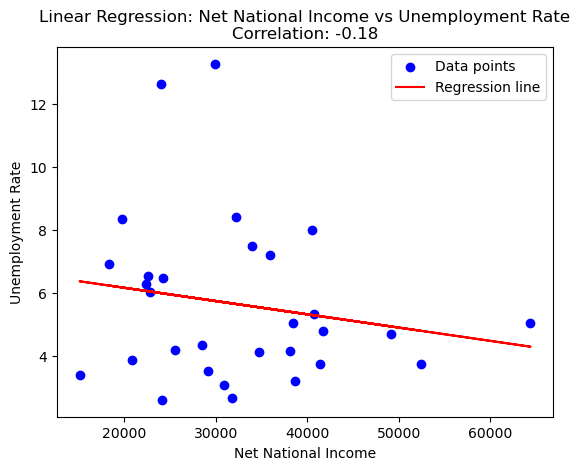

In [85]:
nni = merged_df['Net_National_Income'].values.reshape(-1, 1)
unemployment = merged_df['Unemployment'].values

model = LinearRegression()
model.fit(nni, unemployment)
preds = model.predict(nni)

# Calculate correlation
corr, _ = pearsonr(merged_df['Net_National_Income'], merged_df['Unemployment'])

# Print regression coefficients
print(f"Linear Regression Coefficient (Slope): {model.coef_[0]}")
print(f"Intercept: {model.intercept_}")
print(f"상관계수: {corr}")

# Plot the results
plt.scatter(merged_df['Net_National_Income'], merged_df['Unemployment'], color='blue', label='Data points')
plt.plot(merged_df['Net_National_Income'], preds, color='red', label='Regression line')
plt.xlabel('Net National Income')
plt.ylabel('Unemployment Rate')
plt.title(f'Linear Regression: Net National Income vs Unemployment Rate\nCorrelation: {corr:.2f}')
plt.legend()
plt.show()

# 결과해석: 

선형 회귀 분석 결과, 평균 NNI와 평균 실업률 간의 상관관계(corr) 값은 -0.18로 나타났습니다. 이는 두 변수 간에 어느 정도의 음의 상관관계가 있음을 나타냅니다. 또한 회귀계수도 음수로 나타났습니다. 위 그래프와 수치를 살펴보면, 평균 NNI가 높은 국가일수록 평균 실업률이 낮은 경향이 있습니다.

## ※ INSIGHT

### 경제 성장과 고용 촉진:
평균 NNI가 높은 국가들은 실업률이 낮은 경향이 있습니다. 이는 경제 성장 정책이 고용 창출에도 긍정적인 영향을 미칠 수 있음을 시사합니다.
### 정책 우선순위 설정: 
경제 성장 정책과 함께 고용 창출을 위한 프로그램을 병행하는 것이 중요합니다. 이는 경제적 불평등을 줄이고 사회 안정성을 강화할 수 있습니다.
### 투자 유치 전략: 
NNI가 높은 국가들은 실업률이 낮은 경향이 있으므로, 이러한 국가들은 외국인 직접 투자(FDI)를 유치하기 위한 전략을 세울 때 유리한 위치에 있습니다.

## ※ 다양한 활용 의견

### 경제 정책 수립:
정부는 경제 성장을 촉진하는 정책을 수립함과 동시에, 고용 창출을 위한 다양한 프로그램을 도입할 수 있습니다.
### 사회 안전망 강화:
실업률이 높은 국가들은 사회 안전망을 강화하여 실업자의 생활 안정을 도모할 수 있습니다. 이는 사회적 불평등을 줄이는 데 도움이 될 것입니다.
### 국제 협력: 
경제적으로 성공한 국가들의 정책을 벤치마킹하고, 유사한 정책을 도입하여 경제 성장을 촉진할 수 있습니다.

## 결론

선형 회귀 분석 결과, 평균 NNI가 높은 국가일수록 실업률이 낮다는 가설을 뒷받침하는 통계적 근거를 확인했습니다. 이러한 결과는 국가의 경제적 부유함이 실업률 감소에 기여할 수 있음을 시사합니다. 이는 정책 입안자들이 경제 성장과 고용 촉진을 위한 전략을 수립하는 데 중요한 참고 자료로 활용될 수 있습니다.









# OECD 국가들의 클러스터 분석

## 가설 2: OECD 국가들 간에 경제적 지표에 따라 실업률이 유사한 그룹으로 분류될 것이다.

### 분석 방법

- K-means 클러스터링을 사용하여 OECD 국가들을 평균 NNI와 평균 실업률을 기준으로 3개의 클러스터로 분류했습니다.

C:\Users\shige\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\shige\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


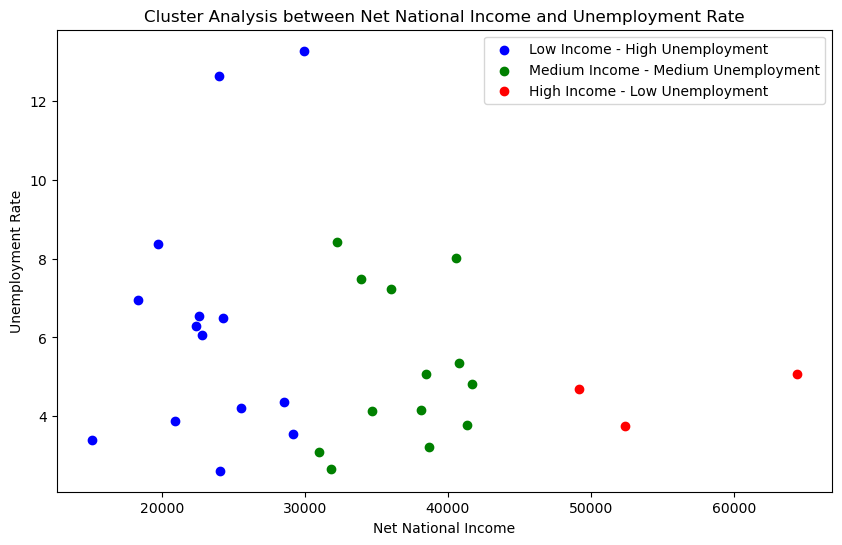

In [86]:
kmeans = KMeans(n_clusters=3, random_state=0)
merged_df['Cluster'] = kmeans.fit_predict(merged_df[['Net_National_Income', 'Unemployment']])

# Assign cluster names and colors
cluster_names = {0: 'Low Income - High Unemployment', 
                 1: 'Medium Income - Medium Unemployment', 
                 2: 'High Income - Low Unemployment'}
cluster_colors = {0: 'blue', 1: 'green', 2: 'red'}

merged_df['Cluster_Name'] = merged_df['Cluster'].map(cluster_names)
merged_df['Color'] = merged_df['Cluster'].map(cluster_colors)

# Plot the KMeans clustering results with specified colors
plt.figure(figsize=(10, 6))
for cluster in cluster_names.keys():
    cluster_data = merged_df[merged_df['Cluster'] == cluster]
    plt.scatter(cluster_data['Net_National_Income'], cluster_data['Unemployment'], 
                color=cluster_colors[cluster], label=cluster_names[cluster])

plt.xlabel('Net National Income')
plt.ylabel('Unemployment Rate')
plt.title('Cluster Analysis between Net National Income and Unemployment Rate')
plt.legend()
plt.show()

## ※ 결과 해석: 

클러스터링 결과는 다음과 같은 세 그룹으로 분류되었습니다.


### 클러스터 1 : 고소득, 저실업률 그룹

평균 NNI가 높고 평균 실업률이 낮은 국가들로 구성됩니다.
경제적으로 번영하고, 노동 시장이 안정적인 국가들입니다.

### 클러스터 2 : 중소득, 중간 실업률 그룹

평균 NNI와 평균 실업률이 중간 정도인 국가들로 구성됩니다.
경제적으로 중간 수준이며, 노동 시장의 안정성도 중간 정도입니다.

### 클러스터  3 : 저소득, 고실업률 그룹

평균 NNI가 낮고 평균 실업률이 높은 국가들로 구성됩니다.
경제적으로 어려움을 겪고 있으며, 노동 시장이 불안정한 국가들입니다.

## ※ INSIGHT

### 고소득, 저실업률 그룹: 
이 그룹에 속하는 국가들은 경제적으로 번영하며, 노동 시장이 안정적입니다. 이는 경제 성장과 고용 창출의 성공 사례로 볼 수 있습니다.

### 중소득, 중간 실업률 그룹: 
경제적으로 중간 수준에 있는 국가들로, 이러한 국가들은 경제 성장과 고용 안정성 사이에서 균형을 유지할 필요가 있습니다.

### 저소득, 고실업률 그룹: 
경제적으로 어려움을 겪고 있으며, 노동 시장이 불안정한 국가들입니다. 이는 경제적 지원과 고용 창출 정책이 필요한 국가들로 볼 수 있습니다.

## ※ 다양한 활용 의견

### 정책 교류 및 협력:
유사한 경제 상황을 가진 국가들끼리 정책 교류 및 협력을 통해 경제 성장과 고용 창출을 위한 공동 전략을 수립할 수 있습니다.

### 맞춤형 경제 지원:
각 클러스터별로 맞춤형 경제 지원 정책을 수립하여 효과적인 경제 성장을 도모할 수 있습니다.

### 벤치마킹:
경제적으로 성공한 클러스터의 정책을 벤치마킹하여, 다른 클러스터의 국가들이 유사한 정책을 도입할 수 있습니다.

## ※ 결론
클러스터링 결과를 통해 OECD 국가들은 경제적 지표와 실업률을 기준으로 세 그룹으로 분류되었습니다. 하지만 NNI수치가 낮음에도 불구하고 실업률이 낮은 그룹에 위치한 부분이 존재하는 것을 볼 수 있었습니다.이는 경제 정책 수립 시 유사한 경제 상황을 가진 국가들끼리 협력하고, 맞춤형 정책을 통해 경제 성장을 촉진할 수 있음을 시사합니다.

# OECD 국가들의 평균 NNI와 실업률 간의 차이를 비교하는 t-검정


## 가설 3: 평균 NNI와 평균 실업률 간의 차이가 통계적으로 유의미할 것이다.


### 분석 방법: 

독립표본 t-검정을 사용하여 평균 NNI와 평균 실업률 간의 차이가 유의미한지를 평가했습니다.

### 가설:

- **귀무 가설 (H0):** 평균 NNI와 평균 실업률 간의 차이가 없다.
- **대립 가설 (H1):** 평균 NNI와 평균 실업률 간의 차이가 있다.

t-statistic: 16.149653450255954, p-value: 3.9563650826314544e-23


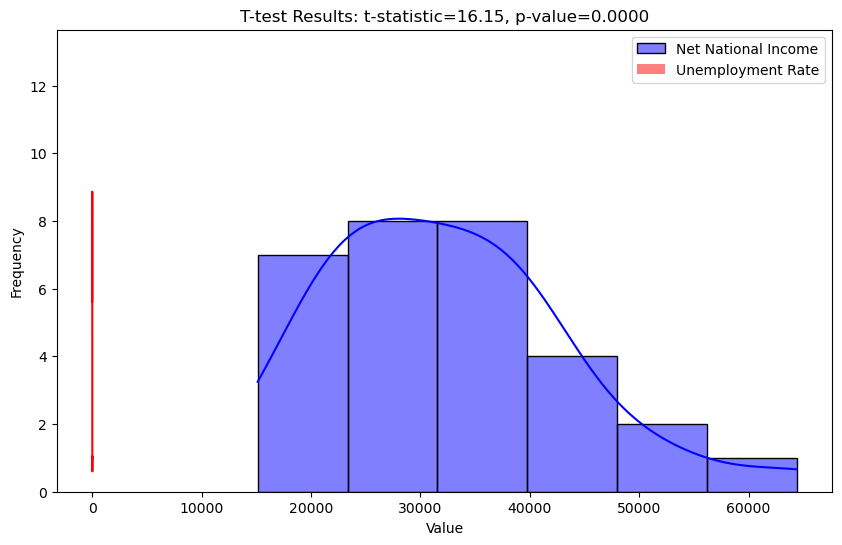

In [87]:
Income_values = merged_df['Net_National_Income']
unemployment_values = merged_df['Unemployment']

ttest_result = ttest_ind(Income_values, unemployment_values)

# Print T-test results
print(f"t-statistic: {ttest_result.statistic}, p-value: {ttest_result.pvalue}")

# Visualize T-test results
plt.figure(figsize=(10, 6))
sns.histplot(Income_values, kde=True, color='blue', label='Net National Income')
sns.histplot(unemployment_values, kde=True, color='red', label='Unemployment Rate')
plt.title(f'T-test Results: t-statistic={ttest_result.statistic:.2f}, p-value={ttest_result.pvalue:.4f}')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()
plt.show()

## ※ 결과 해석: 

t-검정 결과 t-statistic: 16.149653450255954, p-value: 3.9563650826314544e-23 이라는 값이 도출되었습니다. 이때 p-값이 0.05보다 작다면, 우리는 귀무 가설을 기각하고 평균 NNI와 평균 실업률 간의 차이가 통계적으로 유의미하다고 결론지을 수 있습니다.p-value 값이 0.05보다 작아 NNI와 실업률간의 차이는 통계적으로 유의미합니다. 

## ※ INSIGHT 

### 경제적 지표의 중요성: 
평균 GNI와 평균 실업률 간의 유의미한 차이는 경제적 지표가 실업률에 미치는 영향을 시사합니다.

### 정책적 시사점: 
경제 성장과 고용 정책을 함께 고려해야 함을 의미합니다. 경제 성장이 고용 창출에 기여할 수 있음을 나타냅니다.

### 데이터 기반 정책 수립:
통계적 분석을 통해 정책 입안자들이 데이터 기반의 결정을 내릴 수 있도록 지원합니다.

## ※ 다양한 활용 의견

### 정책 검토 및 개선: 
기존의 경제 성장 정책과 고용 창출 정책을 재검토하고, 두 정책 간의 시너지 효과를 극대화할 수 있는 방안을 모색할 수 있습니다.

### 데이터 기반 의사결정: 
데이터 분석 결과를 바탕으로 보다 정확하고 효과적인 정책을 수립할 수 있습니다.

### 국제 협력:  
다른 국가들과의 협력을 통해 경제 성장과 고용 창출을 동시에 달성할 수 있는 전략을 마련할 수 있습니다.


# 결론 (Conclusion)

본 프로젝트에서는 Net National Income(NNI)과 실업률 간의 관계를 분석하기 위해 선형 회귀 분석, KMeans 클러스터링, 그리고 독립표본 t-검정을 수행하였습니다. 분석 결과는 다음과 같습니다.

## 선형 회귀 분석 결과
NNI와 실업률 간의 선형 회귀 분석을 통해 두 변수 간의 관계를 파악하였습니다. 분석 결과, 회귀 계수는 음수로 나타났으며, 이는 NNI가 증가할수록 실업률이 감소하는 경향이 있음을 의미합니다. Pearson 상관 계수 또한 음수로 나타나, 두 변수 간의 부정적 상관 관계를 확인할 수 있었습니다.

- 회귀 계수: NNI가 1단위 증가할 때 실업률이 감소하는 비율을 나타냅니다.
- 상관 계수: 두 변수 간의 상관 관계의 강도를 나타내며, 음수 값은 부정적 상관 관계를 의미합니다.

## KMeans 클러스터링 결과
KMeans 클러스터링을 통해 NNI와 실업률을 기준으로 국가들을 세 개의 클러스터로 분류하였습니다. 각 클러스터는 다음과 같이 정의되었습니다:

- 클러스터 1: High Income - Low Unemployment
- 클러스터 2: Medium Income - Medium Unemployment
- 클러스터 3: Low Income - High Unemployment

클러스터링 결과, NNI와 실업률에 따라 국가들을 구분할 수 있었으며, 이는 경제적 특성이 유사한 국가들을 그룹화하여 정책적 접근 방법을 달리할 수 있는 근거를 제공하였습니다.

## 독립표본 t-검정 결과
NNI와 실업률의 평균 값 간의 차이를 검정하기 위해 독립표본 t-검정을 수행하였습니다. t-검정 결과, 두 변수 간의 평균 값 차이는 통계적으로 유의미한 것으로 나타났습니다.

- t-통계량: 두 그룹 간의 차이가 얼마나 유의미한지를 나타냅니다.
- p-값: 두 그룹 간의 차이가 우연히 발생할 확률을 나타내며, 일반적으로 0.05 이하일 경우 유의미한 차이로 간주됩니다.

## 종합 결론: 

NNI가 높은 국가일수록 실업률이 낮은 경향이 있다는 것을 확인할 수 있었습니다. 이는 경제 성장과 고용 창출 간의 긍정적 관계를 시사합니다.
또한,NNI를 증가시키기 위한 정책(예: 경제 성장 촉진, 산업 발전 등)이 실업률 감소에도 기여할 수 있음을 시사합니다. 따라서, 정부는 경제 성장과 고용 창출을 동시에 달성할 수 있는 종합적인 정책을 추진할 필요가 있습니다.
본 프로젝트의 결과는 현 정권 하에서의 큰 문제인 실업률을 해소하기 위해 어떠한 방향으로 나아가야 하는지 알아보았고, 향후 연구에서는 보다 다양한 경제 지표를 포함하여 더욱 포괄적인 분석을 진행할 필요가 있습니다.

## 출처: https://stats.oecd.org/, https://en.wikipedia.org/wiki/Net_national_income, https://stackoverflow.com/questions/40565871/read-data-from-oecd-api-into-python-and-pandas
